# 0.3.2 - Introduction to Data in R - Part 2

COMET Team <br> *Colby Grimes, Colby Chamber, Jonathan Graves, Manas
Mridul, Valeria Zolla*  
2023-07-09

## Outline

### Prerequisites

-   Introduction to Data in R - Part 1

### Learning Outcomes

In this notebook, you will learn about:

-   Filtering, segmenting, combining and cleaning datasets with
    `tidyverse` and base R
-   Reshaping and presenting data in different kinds of formats

### References

-   [Introduction to Probability and Statistics Using
    R](https://mran.microsoft.com/snapshot/2018-09-28/web/packages/IPSUR/vignettes/IPSUR.pdf)
-   [DSCI 100 Textbook](https://datasciencebook.ca/index.html)

In [ ]:
# run this cell
source("getting_started_intro_to_data_tests_2.r")
# loading in our packages
library(tidyverse)
library(haven)

## Part 1: Data Cleaning

The World Development Indicators (WDI) is the primary World Bank
collection of development indicators, compiled from officially
recognized international sources.

We have used World Bank’s DataBank applet to select and import some
macro and development-related time series data for the countries Canada,
India, Mexico, South Africa, and Zimbabwe for years 2014-2022.

In [ ]:
# importing required packages
library(readr)
library(dplyr)
library(tidyr)
library(stringr)

#Loading the CSV file using the URL 
file_path <- "datasets/WDI_raw.csv"

wdi <- read_csv(file_path) %>%
       rename(Series_Code = "Series Code", Series_Name = "Series Name",
       Country = "Country Name", Country_Code = "Country Code")

head(wdi, 10)

In [ ]:
dim(wdi)

The data frame is in long format. Each unique value in `Series_Name` an
entry for a row, and not a column. As an example:

| Country | Year |   Var | Value |
|--------:|-----:|------:|------:|
|  Canada | 2017 | Var A | Value |
|  Canada | 2017 | Var B | Value |
|  Canada | 2018 | Var C | Value |
|  Canada | 2018 | Var B | Value |
|  Canada | 2018 | Var C | Value |

A simpler version of the data frame in a **wide-format** could look like
this:

| Country | Year | Var A | Var B | Var C |
|--------:|-----:|------:|------:|------:|
|  Canada | 2017 | Value | Value | Value |
|  Canada | 2018 | Value | Value | Value |

> **Note**: look up the functions `pivot_wider()` and `pivot_longer()`
> to learn how to switch between long and wide formats.

While `Series_Name` contains descriptions for each of the series in the
data frame, `Series_Code` offers a handy way to group variables.

Our `Series_Code` variable follow a taxonomy system. For example, any
code starting with `AG` belongs to a *family of series* related to the
state of agriculture in that country. Let’s see the unique series
families and their sub series names.

In [ ]:
Series_Families <- wdi %>%
                   mutate(Series_Family = substr(`Series_Code`, 1, 2)) %>%    # substring first two characters
                   group_by(Series_Family) %>%    # group by unique vals
                   summarize(Series_Names_Under_Family = paste(unique(`Series_Name`), collapse = ", ")) # for each family, find and paste all `Series_Name`

head(Series_Families, 13)

Let’s create a data frame with series families related to access to
institutions. Those are grouped under `SE` (Schooling), `FX` (Financial
Institutions) and `EG` (Electricity). Let’s call our dataset
`access_wdi`.

In [ ]:
prefixes <- c("SE", "EG", "FX")

access_wdi <- wdi %>% 
              filter(str_detect(`Series_Code`, str_c("^", prefixes, collapse = "|")))

access_wdi <- access_wdi %>%  
              rename_with(~str_extract(., "\\d{4}"), starts_with("20")) # rename year columns to follow the 2XYZ format.

head(access_wdi, 5)

### Handling missing values

We are interested in seeing if there are any specific years for when the
data was not collected or is missing for *most* of the variables/series.

Let’s look at each of the year columns and count the number of rows with
`NA`.

In [ ]:
year_columns <- c("2018", "2019", "2020", "2021", "2022")

missing_counts <- sapply(year_columns, function(column) sum(is.na(access_wdi[[column]]))) # create custom function to count missing values

print(missing_counts / nrow(access_wdi))

Looks like 98% of the data is missing for the year 2022. It probably
makes sense to drop the 2022 column altogether.

In [ ]:
access_wdi <- access_wdi %>% 
              select(-`2022`)

head(access_wdi, 20)

Now let’s check for missing values *row-wise* - whether there are lots
of NAs for a country-series combination. Let’s check if there are any
particular country-series combination for which the data is missing for
more than 2 years.

In [ ]:
# create new column with NA count by columns for each row
access_wdi$count_na <- rowSums(is.na(access_wdi))

# sort by number of missing vals
access_wdi <- access_wdi %>% 
              arrange(desc(count_na))

select(access_wdi, c("Country_Code", "Series_Code", "count_na"))

This data frame shows that we don’t have *any* data for series beginning
with the `SE` (Schooling) prefix.

> **Think Deeper**: how could you be systematic when choosing whether to
> drop or not NA values? Our panel datasets is indexed by country and
> series, and we’re interested in yearly values over time. Think about
> the options we have to drop NAs: (1) Dropping a series altogether (2)
> Dropping specific countries (3) Dropping specific rows (i.e.,
> country-series pairs)…

Let’s create an array with `Series_Code` to be dropped from our dataset.

In [ ]:
# creating an array of `Series_Code` that need to be dropped from access_wdi

to_drop <- access_wdi %>%
           filter(count_na > 2) %>%
           distinct(Series_Code) %>% unique() 

to_drop <- unlist(to_drop, use.names = FALSE)

to_drop

> **Think Deeper**: what if dropping the missing values leads to low
> sample size issues? One approach is to import data from alternative
> sources and *fill them into* our original data set. This topic is
> beyond the scope of this notebook, but think about the implications of
> filling in data to the study.

Let’s now drop all the rows where `Series_Code` matches any of the codes
in `to_drop`, and save the resulting data frame as a new version of
`access_wdi`.

In [ ]:
filtered_access_wdi <- access_wdi %>%
                       filter(!(Series_Code %in% to_drop))

filtered_access_wdi

Now the only variables left in this data frame are the `EG` variables,
which indicate the levels of access to electricity and other power
sources within the countries.

This dataset is clearly not appropriate to answer question about the
access to the overall access to institutions; however, it could be
extremely useful if the scope of the research is narrowed to access to
power utilities. For example, we could use the dataset to visualize the
growth in access to energy across the countries over the last 5 years.

### Test your knowledge

Before you complete the following exercises, take a moment to review the
section above. Are there any functions you’re not familiar with? Now is
a good time to learn them.

> **Note**: by running `?function_name` you can get a detailed
> description of any of the functions used in this notebook.

What are some possible ways to deal with NA values? Select all that
apply

1.  Drop them row-wise
2.  Drop them column-wise
3.  Fill them in
4.  Change the scope of the research

In [ ]:
# Enter your answer as a string (in alphabetical order) with your answer choices ex: "ACD"

answer_1 <- 

test_1()

What is normally the best way to deal with missing data?

1.  Drop them row-wise
2.  Drop them column-wise
3.  Fill them in
4.  Change the scope of the research
5.  Impossible to tell

In [ ]:
# Enter your answer as either "A", "B", "C", "D", or "E"

answer_2 <- 

test_2()

## Part 2: Merging data frames in R

Now let’s take a step back and consider an example of merging data
frames. Our WDI data set has macro information on *national incomes*,
*CABs*, *Bank Capital to Assets Ratios,* and various kinds of *CPIA*
ratings. Let’s extract that data and merge it with data from the
Quarterly Public Debt (QPD) data base. The QPD is exactly what you think
it is: a record of sovereign debt managed by the World Bank and the
International Monetary Fund (IMF).

First, to our `wdi` dataset.

In [ ]:
# identify the relevant series families 
prefixes <- c("NY", "FD", "FB", "IQ", "BN")

# subset `wdi` and create `macro_wdi`
macro_wdi <- wdi %>% 
             filter(str_detect(`Series_Code`, str_c("^", prefixes, collapse = "|"))) %>% 
             rename_with(~str_extract(., "\\d{4}"), starts_with("20"))
  
macro_wdi

Again, take note of the missing values! It’s sad that we’re missing the
CPIA rating variables (starting with `IQ`) for all the countries
(Canada, India, Mexico, South Africa and Indonesia). Let’s drop the CPIA
rows.

In [ ]:
macro_wdi <- macro_wdi %>% 
             filter(!(Series_Code %in% c('IQ.CPA.FINS.XQ', 'IQ.CPA.FISP.XQ', 'IQ.CPA.MACR.XQ', 'IQ.CPA.PROP.XQ', 'IQ.CPA.PROT.XQ', 'IQ.CPA.DEBT.XQ', 'IQ.CPA.TRAD.XQ')))

c(macro_wdi$Series_Code %>% 
unique(), macro_wdi$Series_Name %>% 
unique())

So these are the variables we’ll include from the WDI data frame! Now,
let’s load the QPD dataset.

In [ ]:
file_path_2 <- "datasets/qpd.csv"

qpd <- read_csv(file_path_2) %>%
       rename(Series_Code = "Series Code", Series_Name = "Series Name",
              Country = "Country Name", Country_Code = "Country Code")

head(qpd, 25)

The series data in QPD is stored on a quarter-by-year basis. We can
aggregate the data *column-wise* to get yearly amounts.

> **Note**: R usually throws an error if you’re telling it to sum over
> certain rows/columns that include NA values. We resolve this by
> setting the parameter `na.rm = TRUE`, which literally means “NA remove
> is TRUE”.

Before we aggregate the data, let’s check the number of periods for
which data is missing. Again, we’ll look at the country-series
combinations. We do that below with a loop, telling R to *manually* go
over each unique row, count the number of NAs along the period columns,
and then store the result in another dataframe called `status`.

In [ ]:
status <- data.frame()    # empty data-frame that is placeholder for the final data
Series_Codes <- qpd$Series_Code %>% unique()    # gets all `Series_Codes` to iterate over
Countries <- qpd$Country_Code %>% unique()     # gets all `Country_Codes` to iterate over 

for (country_code in Countries) {
    select <- filter(qpd, Country_Code == country_code)    # first filter for the indexed country with `country_code`
  
    for (series_code in Series_Codes) {
        select_further <- filter(select, Series_Code == series_code)    # then filter by for the indexed series with `series_code`
        cols_to_check <- select(select_further, c("2018Q1 [YR2018Q1]", "2018Q2 [YR2018Q2]", "2018Q3 [YR2018Q3]", "2018Q4 [YR2018Q4]",    # then select the period columns 
                                              "2019Q1 [YR2019Q1]", "2019Q2 [YR2019Q2]", "2019Q3 [YR2019Q3]", "2019Q4 [YR2019Q4]",
                                              "2020Q1 [YR2020Q1]", "2020Q2 [YR2020Q2]", "2020Q3 [YR2020Q3]", "2020Q4 [YR2020Q4]",
                                              "2021Q1 [YR2021Q1]", "2021Q2 [YR2021Q2]", "2021Q3 [YR2021Q3]", "2021Q4 [YR2021Q4]",
                                              "2022Q1 [YR2022Q1]", "2022Q2 [YR2022Q2]", "2022Q3 [YR2022Q3]", "2022Q4 [YR2022Q4]"))
        
        # the result will be a single row of period columns for each unique `Country_Code`, `Series_Code` combination
        
        na_count <- sum(is.na(cols_to_check))    # finally, store the value of NAs
        result <- data.frame(Country_Code = country_code, Series_Code = series_code, na_count = na_count)
        status <- rbind(status, result)    # appends the result to the status dataframe and iterate over
  }
}

head(status)

As expected, `status` has three columns: `Country_Code`, `Series_Code`,
and the `na_count`. Now let’s check which combinations have data missing
for less than 20 periods.

In [ ]:
status_to_drop <- status %>% filter(na_count < 20 & na_count > 0) # strictly less than 20
status_to_drop

> **Note**: we filter by `(na_count < 20 & na_count > 0)` because if the
> data is missing for *all* of the 20 columns, the aggregate function
> will take care of the missing values and return `0` as the yearly
> aggregate value. However, if data is missing for strictly less than 20
> period columns, the yearly aggregate values will be under-estimated.

These are the countries-series pairs which we must drop from the
data-frame.

> **Note**: by storing our exploration’s results in `status`, we can
> re-visit our decision to drop values anytime we want. Such proper
> documentation builds trust around the validity of the aggregate
> computations!

Let’s now use `anti_join()` to drop any rows from `qpd` that match the
`Country_Code`, `Series_Code` pairs in `status_to_drop`.

In [ ]:
qpd_filtered <- anti_join(qpd, status_to_drop, by = c("Country_Code", "Series_Code"))
qpd_filtered

> **Note**: `anti_join()` is a function that removes rows from a
> dataframe that have matching values in specified columns with another
> dataframe. In this context, it is used to drop rows from qpd that
> match the `Country_Code` and `Series_Code` pairs in `status_to_drop`,
> resulting in the filtered dataframe `qpd_filtered`.

The code below tells R how to manually go over each unique combination
of `Country`, `Series_Code` values and aggregate quaterly values by
year. To learn exactly what each line does, head to the Appendix!

In [ ]:
# pivot the data from wide to long format, creating separate rows for each quarterly value
qpd_long <- qpd_filtered %>%
  tidyr::pivot_longer(starts_with("20"), names_to = "quarter", values_to = "value")

# extract the year from the "quarter" column
qpd_extracted <- qpd_long %>%
  dplyr::mutate(year = stringr::str_extract(quarter, "\\d+"))

# group the data by country, series, and year for aggregation
qpd_grouped <- qpd_extracted %>%
  dplyr::group_by(Country_Code, Country, Series_Code, Series_Name, year)

# calculate the sum of values for each combination of country, series, and year
qpd_summarized <- qpd_grouped %>%
  dplyr::summarise(total_value = sum(value, na.rm = TRUE))

# pivot the data back to wide format, with separate columns for each year
qpd_aggregated <- qpd_summarized %>%
  tidyr::pivot_wider(names_from = year, values_from = total_value, names_prefix = "year_")

qpd_aggregated

Notice the zeroes in the data frame? As explained earlier, these occur
due to certain pairs of missing data for all of the 20 time periods. We
could filter out these observations if we had to!

### Performing the merge

Now let’s create a new data frame which includes both the macro
variables from WDI and the QPD data. We’ll use `rbind()` to append
observations from `qpd_aggregated` to `macro_wdi`.

In [ ]:
# since the yearly column names are different, we can rename them to match
colnames(qpd_aggregated) <- colnames(macro_wdi)

# combine the data frames using rbind
df_macro <- rbind(macro_wdi, qpd_aggregated)

# print the dimensions of the combined data frame
print(dim(df_macro))

# view the combined data frame
df_macro

## Part 3: Other Types of Merges

Let’s look at a **horizontal merge**. Suppose we were to update
`df_macro` the following values for the year 2023.

In [ ]:
values_2023 <- c(-46898267372, -25575220073, 1457067267, 81641557999, -59663613794, 79677936994, 88935053721, 32159558497, 25822808780, -87642745906, -58805085020, -64688649494, 37404569332, -23179256357, 53968284000, -460151583, 43523701653, 98381218966, -23992964113, 55489044264, 86941046221, -57571495743, 30334753217, -74888980808, -46555866254, -22777181491, -97321933368, -23522408586, 73938169144, -31930200662, -3583976906, 19913165085)

Country <- c("India",  "India", "Canada", "Canada", "Honduras", "Honduras", "Indonesia", "Indonesia", "South Africa", "South Africa", "Mexico",  "Mexico", "United Kingdom", "United Kingdom", "United States", "United States", "China", "China", "Hong Kong SAR, China", "Hong Kong SAR, China", "Netherlands", "Netherlands", "Egypt, Arab Rep.", "Egypt, Arab Rep.", "Georgia", "Georgia", "Slovak Republic", "Slovak Republic", "Georgia", "Honduras", "Indonesia", "Slovak Republic")

Series_Code <- rep(df_macro$Series_Code, length.out = length(values_2023))
Series_Name <- rep(df_macro$Series_Name, length.out = length(values_2023))

series_2023 <- data.frame( Country = Country, Series_Code = Series_Code, Series_Name = Series_Name, values_2023 = values_2023)

head(series_2023, 5)

We can use `merge()` to add the 2023 values column into `df_macro`,
specifiying that we merge by `Country`, `Series_Code`, and
`Series_Name`.

In [ ]:
df_macro_2 <- merge(df_macro, series_2023, by = c("Country", "Series_Code", "Series_Name"))

df_macro_2 <- df_macro_2 %>% 
              rename("2023" = "values_2023")

head(df_macro_2, 5)

Take a look at the image below to learn about other methods for merging.

<figure>
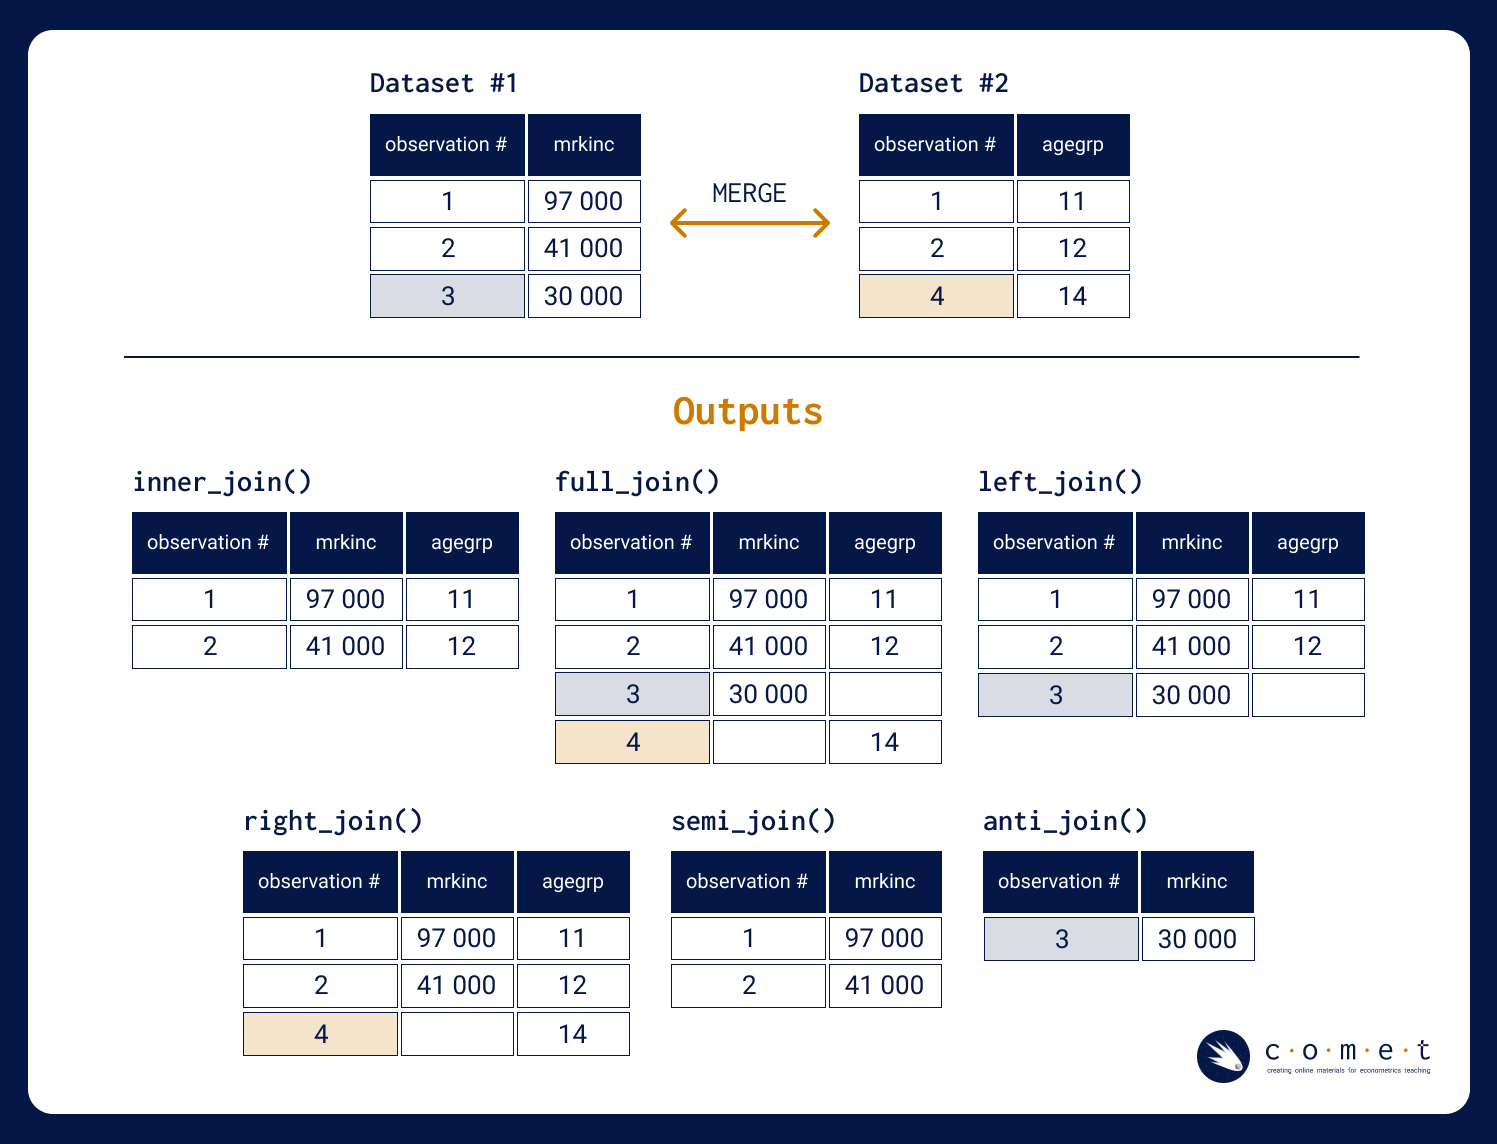
<figcaption aria-hidden="true">Merging Methods - COMET Team</figcaption>
</figure>

As illustrated in the image, a `full_join()` and `right_join()` are
great for merging data sources in situations when we are particularly
interested in the issue of missing matches.For simpler cases,
`inner_join()` is ideal when you only want to include fully matched
observations in the final data set.

### Test your knowledge

Debug the code below to calculate the mean of the vector `set`. Store
the answer in `answer_3`.

In [ ]:
set

In [ ]:
mean(set)

In [ ]:
answer_3 <- 

test_3()

Suppose you have two data frames, `df1` and `df2`. What line of code
should you run if you want to perform a merge and preserve the entries
of `df1`?

1.  `anti_join(df1, df2)`
2.  `right_join(df1, df2)`
3.  `inner_join(df1, df2)`
4.  `left_join(df1, df2)`
5.  Impossible to tell without knowing the entries

In [ ]:
# Enter your answer as either "A", "B", "C", "D", or "E"

answer_4 <- 

test_4()

## Appendix

### More on the wrangling code that aggregates period values in QPD

The following code should produce 5 different data-frames that
incrementally show how our wrangling code for calculating the yearly
aggregates for each Country and Series.

In [ ]:
# select a specific country and series for demonstration (e.g., "USA" and "GDP")
country_code <- "ALB"
series_code <- "DP.DOD.DSCD.CR.PS.CD"

# filter the data for the specific country and series
qpd_example <- qpd_filtered %>%
  dplyr::filter(Country_Code == country_code, Series_Code == series_code)

# pivot the data from wide to long format, creating separate rows for each quarterly value
qpd_long <- qpd_example %>%
  tidyr::pivot_longer(starts_with("20"), names_to = "quarter", values_to = "value")

# show the intermediate result: qpd_long
qpd_long

# extract the year from the "quarter" column
qpd_extracted <- qpd_long %>%
  dplyr::mutate(year = stringr::str_extract(quarter, "\\d+"))

# show the intermediate result: qpd_extracted
qpd_extracted

# group the data by country, series, and year for aggregation
qpd_grouped <- qpd_extracted %>%
  dplyr::group_by(Country_Code, Country, Series_Code, Series_Name, year)

# show the intermediate result: qpd_grouped
qpd_grouped

# calculate the sum of values for each combination of country, series, and year
qpd_summarized <- qpd_grouped %>%
  dplyr::summarise(total_value = sum(value, na.rm = TRUE))

# show the intermediate result: qpd_summarized
qpd_summarized

# pivot the data back to wide format, with separate columns for each year
qpd_aggregated <- qpd_summarized %>%
  tidyr::pivot_wider(names_from = year, values_from = total_value, names_prefix = "year_")

# show the final result: qpd_aggregated
qpd_aggregated